<!-- ## Paper and data:

https://zenodo.org/records/13357926

https://www.nature.com/articles/s41563-024-02016-6

using stem ae and shuyu's affine transform code -->


In [167]:
%load_ext autoreload
%autoreload 2

import tqdm
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('/home/xz498/NaCl_STEM/m3_learning/src/')
sys.path.append('/home/xz498/NaCl_STEM/Gaussian_Sampler/')
# sys.path.append('/home/xz498/anaconda3/envs/nacl_stem/lib/python3.10/site-packages/m3_learning/m3_learning/src')

from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.base_model import Averaging_Loss_AE
import py4DSTEM

from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.viz.printing import printer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import numpy as np

plt.clf();plt.clf()
def get_theta(rotation):
    """_summary_

    Args:
        rotation (array-like): (n,2,3) affine matrix reshapeed into (n,6)

    Returns:
    
        float: _description_
    """    
    acos = np.arccos(rotation[:,0])
    asin = np.arcsin(rotation[:,1])
    theta = asin.copy()

    # asin(+), acos(+) means the angle is accurate
    # asin(-), acos(-) means 3rd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] *= -1 
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] += -np.pi
    # asin(+), acos(-) means 2nd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] *= -1
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] += np.pi/2
    
    return theta

def affines(affines,
            shape_=[255, 256, 256, 256], 
            sc=True,
            sh=True,
            trans=True,
            rot=True,
            name="",
            labelfigs_ = False,
            scalebar_ = None,
            printer = None,
            **kwargs):
    """Plots the embeddings

    Args:
        embedding (tuple of array-like): (scale_shear,rotation,translation) matrices from AffineTransform class.
                                         If not calculated, put None.
        # mod (int, optional): defines the number of columns in the figure. Defaults to 4.
        channels (bool, optional): specific channels to plot. Defaults to False.
        scalebar_ (dict, optional): add the scalebar. Defaults to None.
        shape_ (list, optional): shape of the initial image. Defaults to [265, 256, 256, 256].
        name (str, optional): filename. Defaults to "".
        channels (bool, optional): _description_. Defaults to False.
        labelfigs_ (bool, optional): _description_. Defaults to False.
        add_scalebar (_type_, optional): _description_. Defaults to None.
        printer (_type_, optional): _description_. Defaults to None.
    """        

    scale,shear,rotation,translation = affines

    # # sets the channels to use in the object
    # if channels is None:
    #     channels = range(7)

    num_plots = 2*sh + 2*sc + 2*trans + rot
    # builds the figure
    fig, axs = layout_fig(num_plots, mod=2, **kwargs)

    i=0
    # translation
    if trans:
        imagemap(axs[i], translation[:,2].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], translation[:,5].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('translation x')
        axs[i+1].set_title('translation y')
        i+=2
    # scale_shear
    if sc:
        imagemap(axs[i], scale[:,0].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], scale[:,4].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('scale x')
        axs[i+1].set_title('scale y')
        i+=2
    if sh:
        imagemap(axs[i], shear[:,1].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear x
        imagemap(axs[i+1], shear[:,3].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear y
        axs[i].set_title('shear x')
        axs[i+1].set_title('shear y')
        i+=2
    # rotation
    if rot:
        theta = get_theta(rotation)
        # lim = abs(theta.mean())+abs(3*theta.std())
        imagemap(axs[i], theta.reshape(shape_[-4], shape_[-3]), 
                 divider_=False,**kwargs) # rotation angle
        axs[i].set_title('rotation')

    # adds labels to the figure
    if labelfigs_:
        for i, ax in enumerate(axs):
            labelfigs(ax, i)

    # adds the scalebar
    if scalebar_ is not None:
        add_scalebar(axs.flatten()[-1], scalebar_)

    # prints the image
    if printer is not None:
        printer.savefig(fig,
            f'{name}_affine_maps', tight_layout=False)
        
    # plt.close(fig)
    # return fig, ax


<Figure size 640x480 with 0 Axes>

## Load Data

In [169]:
# Data
file_path = '/home/xz498/NaCl_STEM/Data/'
data_id = 'Hydrated_NaCl_CL_2p7'
step_size = 20 #nm
CL_data = 2.7
file_data = file_path + 'Hydrated_NaCl_CL_2p7.dm4' 

# Calibrant
file_path_Au_cal = file_path +'Calibrant_Hydrated_NaCl_CL_2p7.dm4'
step_size_Au = 10 # nm
CL_calibrant = 2.7

# In case calibration was not taken in a a similar camera length 
CL_correction = CL_calibrant/CL_data 

# Output folder
file_path_output = '/home/xz498/NaCl_STEM/Results/'+data_id+'/'
if os.path.exists(file_path_output):
    print("filePath already exist.")
else:
    os.mkdir(file_path_output)

filePath already exist.


In [170]:
# Decided based on a pre binning testing 
bin_factor = 4

In [171]:
AcquisitionBinning = 4
binProbe = AcquisitionBinning*bin_factor

In [172]:
'''
Real space to q space rotation. 
The angle was experimentaly measured.
rotation_calibration_theta= -0.118682 
in radians, -6.8 degrees 
'''
rotation_calibration = -6.8

In [220]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.base_model import Averaging_Loss_AE
from Gaussian_Sampler.data.datasets import Py4DSTEM_Dataset

dataset = Py4DSTEM_Dataset(file_data, binfactor=bin_factor, 
                           block=10, 
                           center=(88,92),  
                           hot_px_threshold=0.8, 
                           log=True, 
                           standard=False,
                           minmax=True, 
                           stdv_thresh=20.
                           )

Loading dataset...


100%|██████████| 10000/10000 [00:10<00:00, 934.54it/s]


Preprocessing data...
Removing hot pixels...
Total hot pixels = 14
Centering data...
Blocking center beam...
Thresholding 20.0 standard deviations...
Removing NaNs...
Log scaling data...
Minmax scaling data...
Computing to np array...
Done.


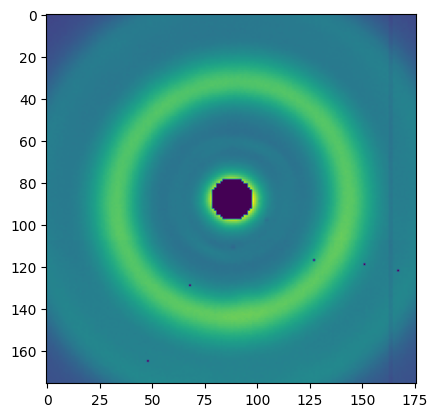

In [257]:
plt.imshow(dataset.log_data.mean(axis=(0)).reshape(176,176))

(array([3.100e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 8.000e+00, 1.500e+01, 4.600e+01, 8.200e+01, 9.800e+01,
        1.270e+02, 1.960e+02, 1.710e+02, 1.600e+02, 1.390e+02, 1.490e+02,
        1.390e+02, 1.250e+02, 1.360e+02, 1.430e+02, 1.360e+02, 1.550e+02,
        1.540e+02, 3.910e+02, 9.110e+02, 1.644e+03, 2.663e+03, 2.506e+03,
        1.999e+03, 2.241e+03, 2.303e+03, 1.684e+03, 9.430e+02, 5.210e+02,
        4.850e+02, 4.520e+02, 4.490e+02, 3.850e+02, 3.840e+02, 3.760e+02,
        3.250e+02, 3.740e+02, 3.190e+02, 3.460e+02, 3.040e+02, 3.410e+02,
        2.950e+02, 3.360e+02, 2.830e+02, 3.270e+02, 2.890e+02, 3.240e+02,
        3.320e+02, 3.440e+02, 3.330e+02, 3.900e+02, 4.040e+02, 4.970e+02,
        7.130e+02, 5.240e+02, 3.580e+02, 1.940e+02, 7.500e+01, 3.200e+01,
        6.000e+00, 8.000e+00, 9.000e+0

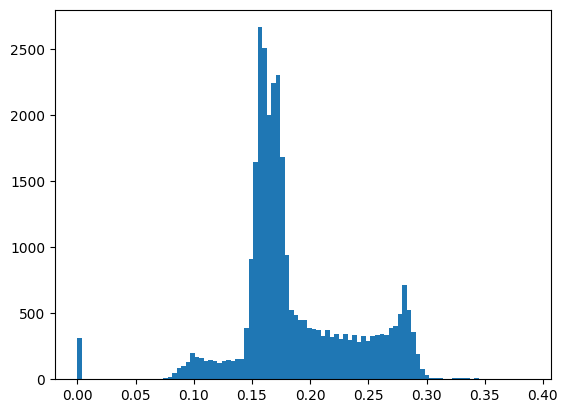

In [258]:
plt.hist(dataset.log_data.mean(axis=(0)).flatten(), bins=100)

### misc

In [ ]:
###

In [8]:
# plt.hist(dataset.log_data.flatten(),bins=50)
# plt.show()

In [9]:
# plt.clf();plt.clf()
# plt.imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
# for num in np.unique(wh[:,0]):
#     plt.plot(num%100, num//100, 'ro', markerfacecolor='none')
# plt.show()
    

In [10]:
# j=0
# plt.clf();plt.clf()
# for num in np.unique(wh[:,0]):
#     print(num)
#     plt.imshow(dataset.log_data[num])
#     while j<len(wh) and wh[j,0]==num:
#         plt.plot(wh[j,2], wh[j,1], 'ro', markerfacecolor='none')
#         j+=1
#     plt.show();

<Figure size 640x480 with 0 Axes>

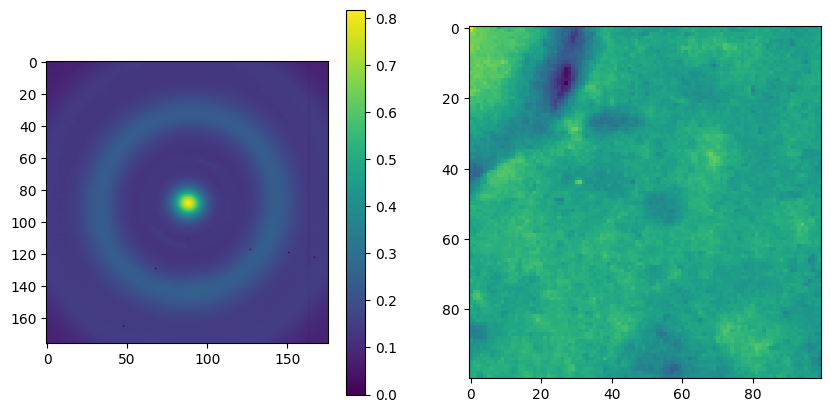

In [45]:
plt.clf()
fig, ax = plt.subplots(1,2, figsize=(10,5))
a = ax[0].imshow(dataset.log_data.mean(axis=0))
ax[1].imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
plt.colorbar(a)
plt.show()

### pca

In [221]:
from sklearn.decomposition import PCA

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
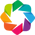

In [253]:
import holoviews as hv
import panel as pn
hv.extension('bokeh')
pn.extension('bokeh')
a_, b_, x_, y_ = dataset.shape
data = dataset.log_data.reshape(a_, b_, x_, y_)

slider_x = pn.widgets.IntSlider(name='x', start=0, end=x_-1, step=1)
slider_y = pn.widgets.IntSlider(name='y', start=0, end=y_-1, step=1)
slider_a = pn.widgets.IntSlider(name='a', start=0, end=a_-1, step=1)
slider_b = pn.widgets.IntSlider(name='b', start=0, end=b_-1, step=1)

@pn.depends(x=slider_x, y=slider_y)
def update_realspace_slice(x, y):
    return hv.Image(data[:,:, x, y],
                    bounds=(0, 0, a_, b_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Realspace Slice')

@pn.depends(a=slider_a, b=slider_b)
def update_diffraction_slice(a, b):
    return hv.Image(data[a, b], 
                    bounds=(0, 0, x_, y_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Diffraction Slice')

mean_realspace = hv.Image(data.mean(axis=(2,3)).T, 
                          bounds=(0, 0, a_, b_)
                          ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)
mean_diffraction = hv.Image(data.mean(axis=(0,1)), 
                            bounds=(0, 0, x_, y_)
                            ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)

dmap_realspace = hv.DynamicMap(update_realspace_slice)
dmap_diffraction = hv.DynamicMap(update_diffraction_slice)

def plot_red_dot(x, y): 
    return hv.Points([(x, y)]).opts(color='red', size=3,
                           aspect='equal',)

@pn.depends(x=slider_x, y=slider_y)
def update_diffraction_dot(x, y): 
    return plot_red_dot(x, y)

@pn.depends(a=slider_a, b=slider_b)
def update_realspace_dot(a, b): 
    return plot_red_dot(a, b)

dmap_realspace_dot = hv.DynamicMap(update_realspace_dot)
dmap_diffraction_dot = hv.DynamicMap(update_diffraction_dot)

layout = pn.Column(
    pn.Row(slider_x, slider_y),
    pn.Row(slider_a, slider_b),
    
    
    pn.panel((mean_realspace * dmap_realspace_dot + \
        mean_diffraction * dmap_diffraction_dot).opts(shared_axes=False)),
    
    pn.panel((dmap_realspace * dmap_realspace_dot + \
        dmap_diffraction * dmap_diffraction_dot).opts(shared_axes=False))
)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
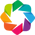

BokehModel(combine_events=True, render_bundle={'docs_json': {'e0e37b5e-583f-42fc-8820-50481e5a56c7': {'version…

In [254]:
import holoviews as hv
import panel as pn
hv.extension('bokeh')
pn.extension('bokeh')
a_, b_, x_, y_ = dataset.shape
data = dataset.log_data.reshape(a_, b_, x_, y_)

slider_x = pn.widgets.IntSlider(name='x', start=0, end=x_-1, step=1)
slider_y = pn.widgets.IntSlider(name='y', start=0, end=y_-1, step=1)
slider_a = pn.widgets.IntSlider(name='a', start=0, end=a_-1, step=1)
slider_b = pn.widgets.IntSlider(name='b', start=0, end=b_-1, step=1)

def update_realspace_slice(x, y):
    return hv.Image(data[:,:, x, y],
                    bounds=(0, 0, a_, b_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Realspace Slice')

def update_diffraction_slice(a, b):
    return hv.Image(data[a, b], 
                    bounds=(0, 0, x_,y_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Diffraction Slice')

mean_realspace = hv.Image(data.mean(axis=(2,3)).T, 
                          bounds=(0, 0, a_, b_)
                          ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)
mean_diffraction = hv.Image(data.mean(axis=(0,1)), 
                            bounds=(0, 0, x_, y_)
                            ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)

dmap_realspace = hv.DynamicMap(pn.bind(update_realspace_slice, x=slider_x, y=slider_y))
dmap_diffraction = hv.DynamicMap(pn.bind(update_diffraction_slice, a=slider_a, b=slider_b))

def plot_red_dot(x, y): 
    return hv.Points([(x, y)]).opts(color='red', size=3,
                           aspect='equal',)

def update_diffraction_dot(x, y): 
    return plot_red_dot(x, y)

def update_realspace_dot(a, b): 
    return plot_red_dot(a, b)


dmap_realspace_dot = hv.DynamicMap(pn.bind(update_realspace_dot, a=slider_a, b=slider_b))
dmap_diffraction_dot = hv.DynamicMap(pn.bind(update_diffraction_dot, x=slider_x, y=slider_y))

layout = pn.Column(
    pn.Row(slider_x, slider_y),
    pn.Row(slider_a, slider_b),
    
    (mean_realspace * dmap_realspace_dot + \
    mean_diffraction * dmap_diffraction_dot).opts(shared_axes=False),
    
    (dmap_realspace * dmap_realspace_dot + \
    dmap_diffraction * dmap_diffraction_dot).opts(shared_axes=False)
)

layout


In [234]:
layout.clear()

[Row
     [0] IntSlider(end=175, name='x')
     [1] IntSlider(end=175, name='y'),
 Row
     [0] IntSlider(end=99, name='a')
     [1] IntSlider(end=99, name='b'),
 HoloViews(Layout),
 HoloViews(Layout)]

<Figure size 640x480 with 0 Axes>

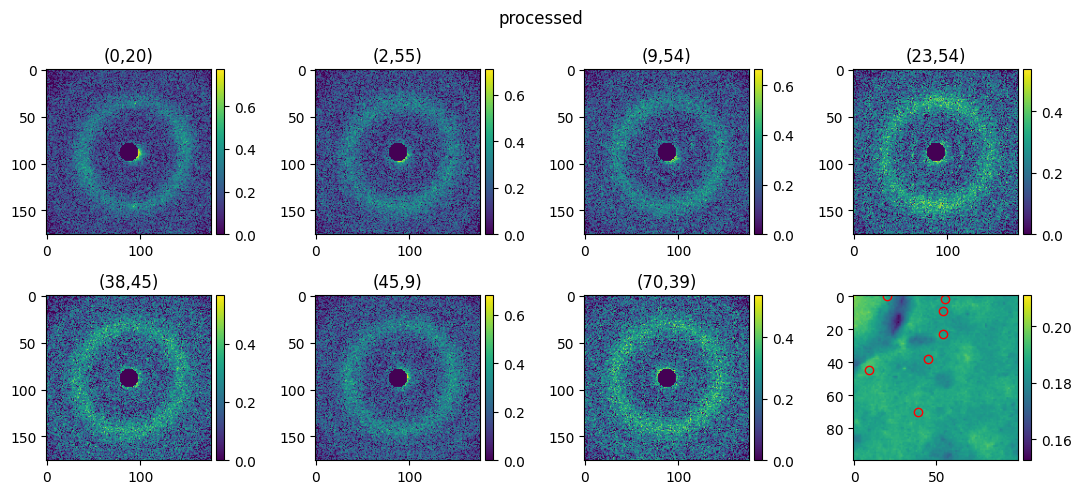

In [224]:
from m3_learning.viz.layout import layout_fig, add_colorbar
 
plt.clf();plt.clf()
fig,ax = plt.subplots(2,4, figsize=(11,5))
ax=ax.flatten()
fig.suptitle('processed')

a=ax[-1].imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
add_colorbar(ax[-1], a)
for i,n in enumerate([20,255,954,2354,3845,4509,7039]):
# for i in range(20):
    x_,y_ = n//100, n%100
    a=ax[i].imshow(dataset.log_data[n,:,:])
    add_colorbar(ax[i], a)
    ax[i].set_title(f"({x_},{y_})")
    ax[-1].plot(y_,x_, 'ro', markerfacecolor='none')
    fig.tight_layout()
plt.show()

In [231]:
pca = PCA(n_components=32)

output = pca.fit_transform(dataset.log_data.reshape(dataset.log_data.shape[0],-1))

In [232]:
import matplotlib.pyplot as plt
pca = PCA(n_components=50)
# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

<Figure size 1000x600 with 0 Axes>

AttributeError: 'PCA' object has no attribute 'components_'

<Figure size 640x480 with 0 Axes>

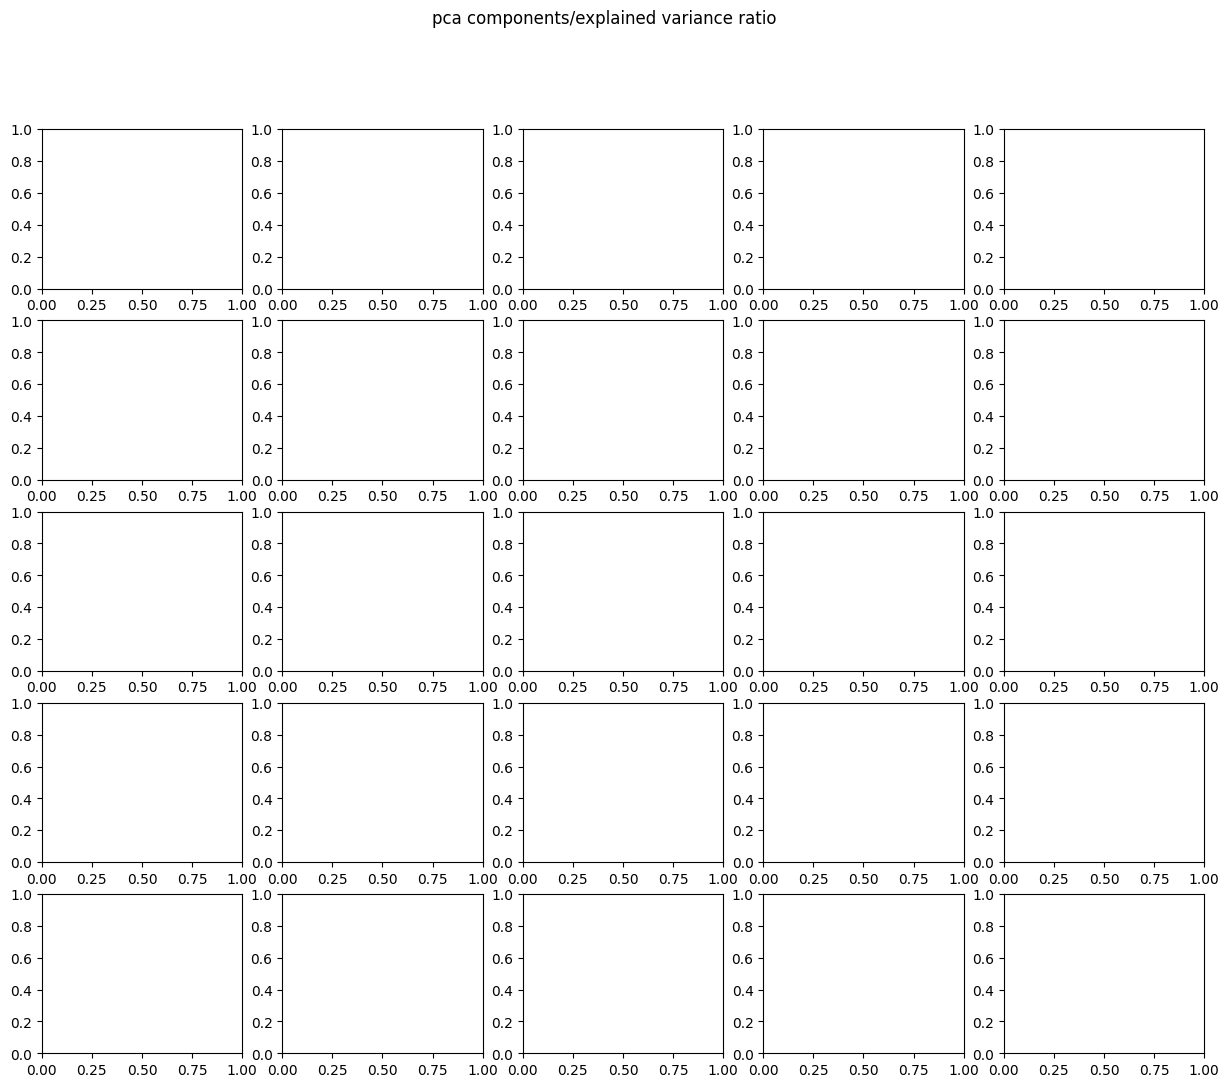

In [229]:
import matplotlib.pyplot as plt
plt.clf();plt.clf()
fig,axs = plt.subplots(5,5,figsize=(15,12))
axs = axs.flatten()
fig.suptitle('pca components/explained variance ratio')
for i in range(25):
    a=axs[i].imshow(pca.components_[i].reshape(dataset.log_data.shape[1],
                                               dataset.log_data.shape[2]))
    add_colorbar(axs[i], a)
    axs[i].set_title(f"{i}: {pca.explained_variance_ratio_[i]:.2e}")
fig.tight_layout()
plt.show()

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

<Figure size 640x480 with 0 Axes>

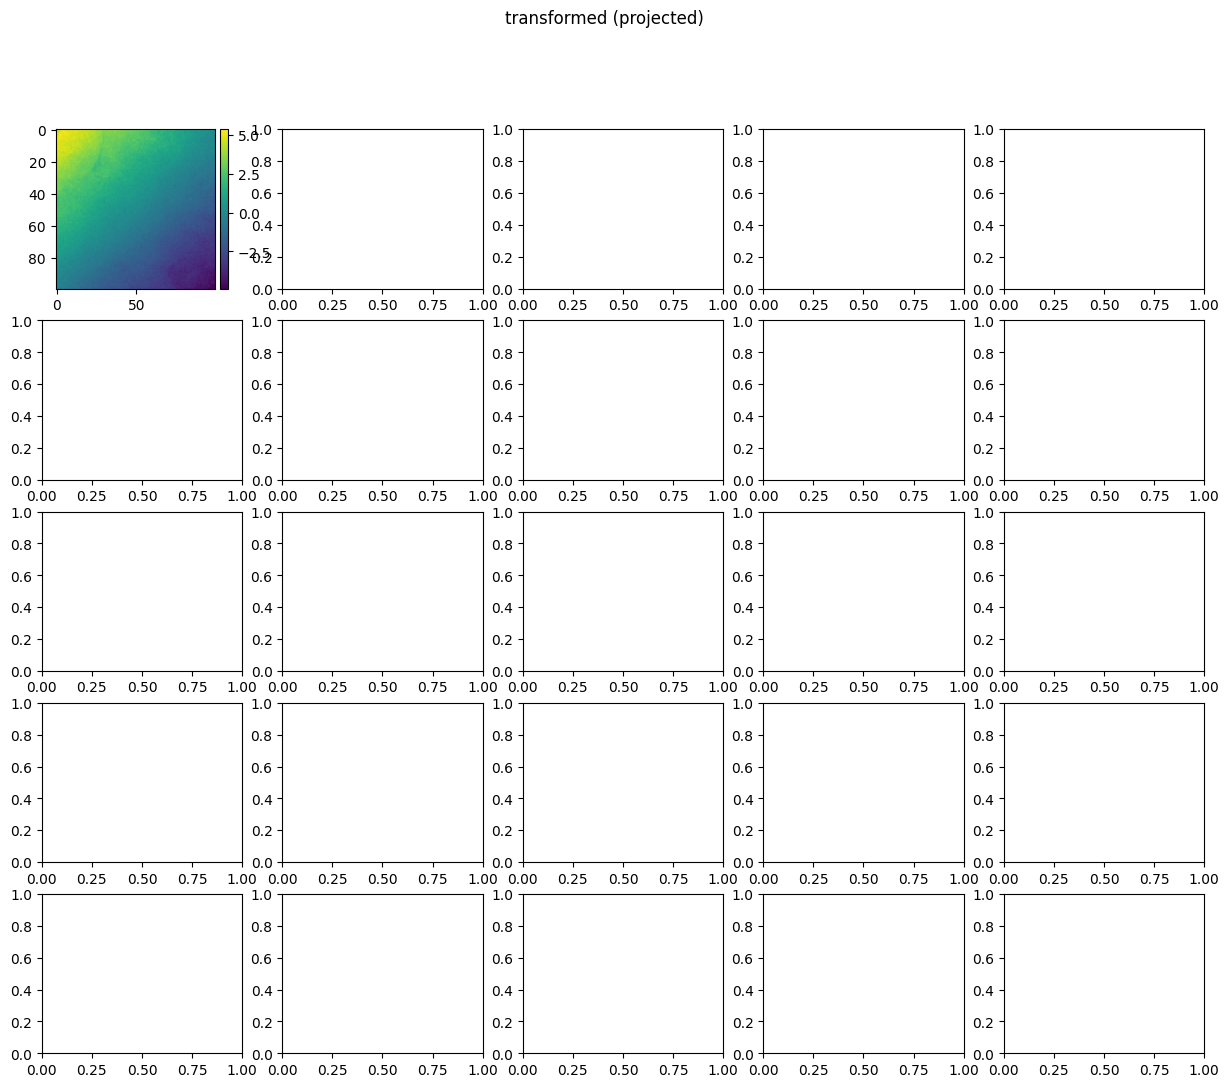

In [230]:
import matplotlib.pyplot as plt
plt.clf();plt.clf()
fig,axs = plt.subplots(5,5,figsize=(15,12))
axs = axs.flatten()
fig.suptitle('transformed (projected)')
for i in range(25):
    a=axs[i].imshow(output[:,i].reshape(100,100))
    add_colorbar(axs[i], a)
    axs[i].set_title(f"{i}: {pca.explained_variance_ratio_[i]:.2e}")
fig.tight_layout()
plt.show()

In [ ]:
output[:, :10] = 0
recon = pca.inverse_transform(output)

In [ ]:
from m3_learning.viz.layout import layout_fig, add_colorbar
 
plt.clf();plt.clf()
# min_, max_ = recon.min(), recon.max()
fig,ax = plt.subplots(2,4, figsize=(10,5))
ax=ax.flatten()
fig.suptitle('reconstructed')

a=ax[-1].imshow(recon.mean(axis=(-1)).reshape(100,100))
add_colorbar(ax[-1], a)
for i,n in enumerate([20,255,954,2354,3845,4509,7039]):
# for i in range(20):
    x_,y_ = n//100, n%100
    a=ax[i].imshow(recon[n].reshape(176,176), vmin=0.0, vmax=0.05)
    add_colorbar(ax[i], a)
    ax[i].set_title(f"({x_},{y_})")
    ax[-1].plot(y_,x_, 'ro', markerfacecolor='none')

fig.tight_layout()
fig

## Train with Gaussian Sampling

### look at sampler

In [174]:
sampler = Gaussian_Sampler(dset = dataset,
                           orig_shape = dataset.data.shape,
                           batch_size = 64,
                           gaussian_std = 0.5,
                           num_neighbors = 8)

In [175]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler, custom_collate_fn
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        sampler = sampler,
                        collate_fn = custom_collate_fn)


ImportError: cannot import name 'custom_collate_fn' from 'Gaussian_Sampler.data.custom_sampler' (/home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/data/custom_sampler.py)

In [130]:
next(iter(dataloader)).shape

torch.Size([64, 176, 176])

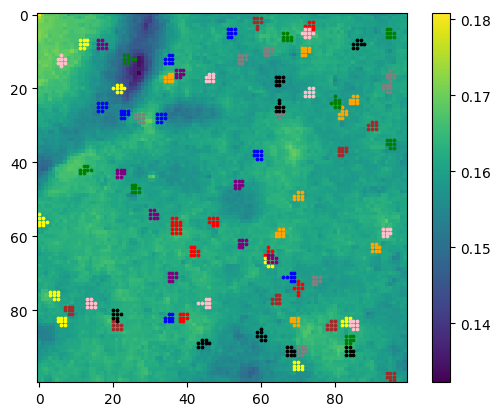

In [153]:
import numpy as np
colors = 'red, orange, yellow, green, blue, purple, pink, brown, gray, black'.split(', ')
plt.clf(); plt.clf()
plt.imshow(dataset.log_data.mean(axis=(1,2)).reshape(dataset.data.shape[:2]))
plt.colorbar()
for i,col in enumerate(colors):
    sample = next(iter(sampler))
    coords = np.array([[sam//dataset.data.shape[0], sam%dataset.data.shape[0]] for sam in sample])
    plt.scatter(coords[:,0],coords[:,1],s=3,color=col,)
plt.show()

### 22,22 model 5k

In [176]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=Gaussian_Sampler,
                     sampler_kwargs={'dset': dataset,
                                     'orig_shape': dataset.data.shape,
                                     'batch_size': 64,
                                     'gaussian_std': 0.5,
                                     'num_neighbors': 8},
                     collate_fn=Gaussian_Sampler.custom_collate_fn,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 64,
                                               'kernel_size': 3,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 3.1415,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [3,3], 
                                        'embedding_size': 64, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 64,
                                        'kernel_size': 3,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [11,11], 
                                        'upsampling_list': [4,4], 
                                        'embedding_size': 64, 
                                        'conv_size': 64,
                                        'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                  #    # STEM AE kwargs:
                  #    encoder_step_size=[176, 176],
                  #    pooling_list=[4],
                  #    decoder_step_size=[22, 22],
                  #    upsampling_list=[8],
                  #    embedding_size=32,
                  #    conv_size=128,
                  #   #  device='cuda:1',
                  #    learning_rate=3e-5
                    )

In [177]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=10,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_gauss_k3/",
        # batch_size=32,
)

  0%|          | 0/156 [00:00<?, ?it/s]

 99%|█████████▉| 155/156 [01:08<00:00,  2.25it/s]


Epoch: 000/010 | Train Loss: 0.0127
.............................


 99%|█████████▉| 155/156 [01:11<00:00,  2.17it/s]


Epoch: 001/010 | Train Loss: 0.0083
.............................


 99%|█████████▉| 155/156 [01:12<00:00,  2.14it/s]


Epoch: 002/010 | Train Loss: 0.0082
.............................


 99%|█████████▉| 155/156 [01:11<00:00,  2.18it/s]


Epoch: 003/010 | Train Loss: 0.0082
.............................


 22%|██▏       | 34/156 [00:15<00:56,  2.16it/s]


KeyboardInterrupt: 

In [140]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_samp_k3/(2024-11-26_14-46-32)_epoch:0009_trainloss:3.6785e-02.pkl' 


model.checkpoint = checkpoint
model.load_weights(checkpoint)

/home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_checkpoint)


In [178]:
model.get_embeddings(dataset.log_data, batch_size=32)


creating /home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_gauss_k3/_embedding.h5 file
creating new embedding and affine h5 datasets


100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


<Figure size 640x480 with 0 Axes>

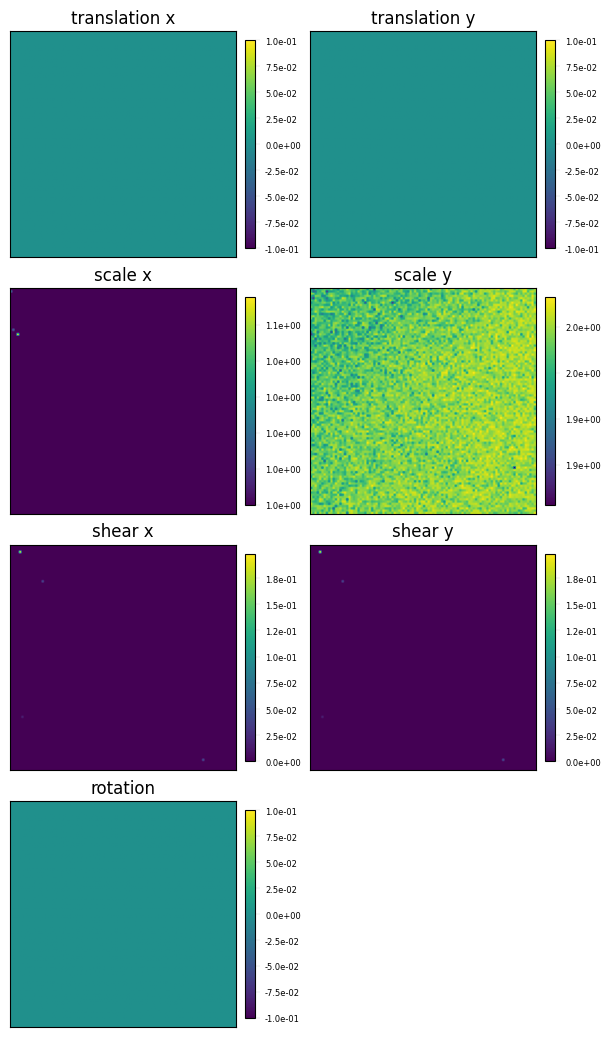

In [179]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    keys=list(h.keys())
    plt.clf();plt.clf()
    affines([ h[keys[2]][:], h[keys[3]][:], h[keys[4]][:], h[keys[1]][:]],
            shape_=[100, 100,176,176], 
            scale=True,
            shear=True,
            trans=True,
            rot=True)

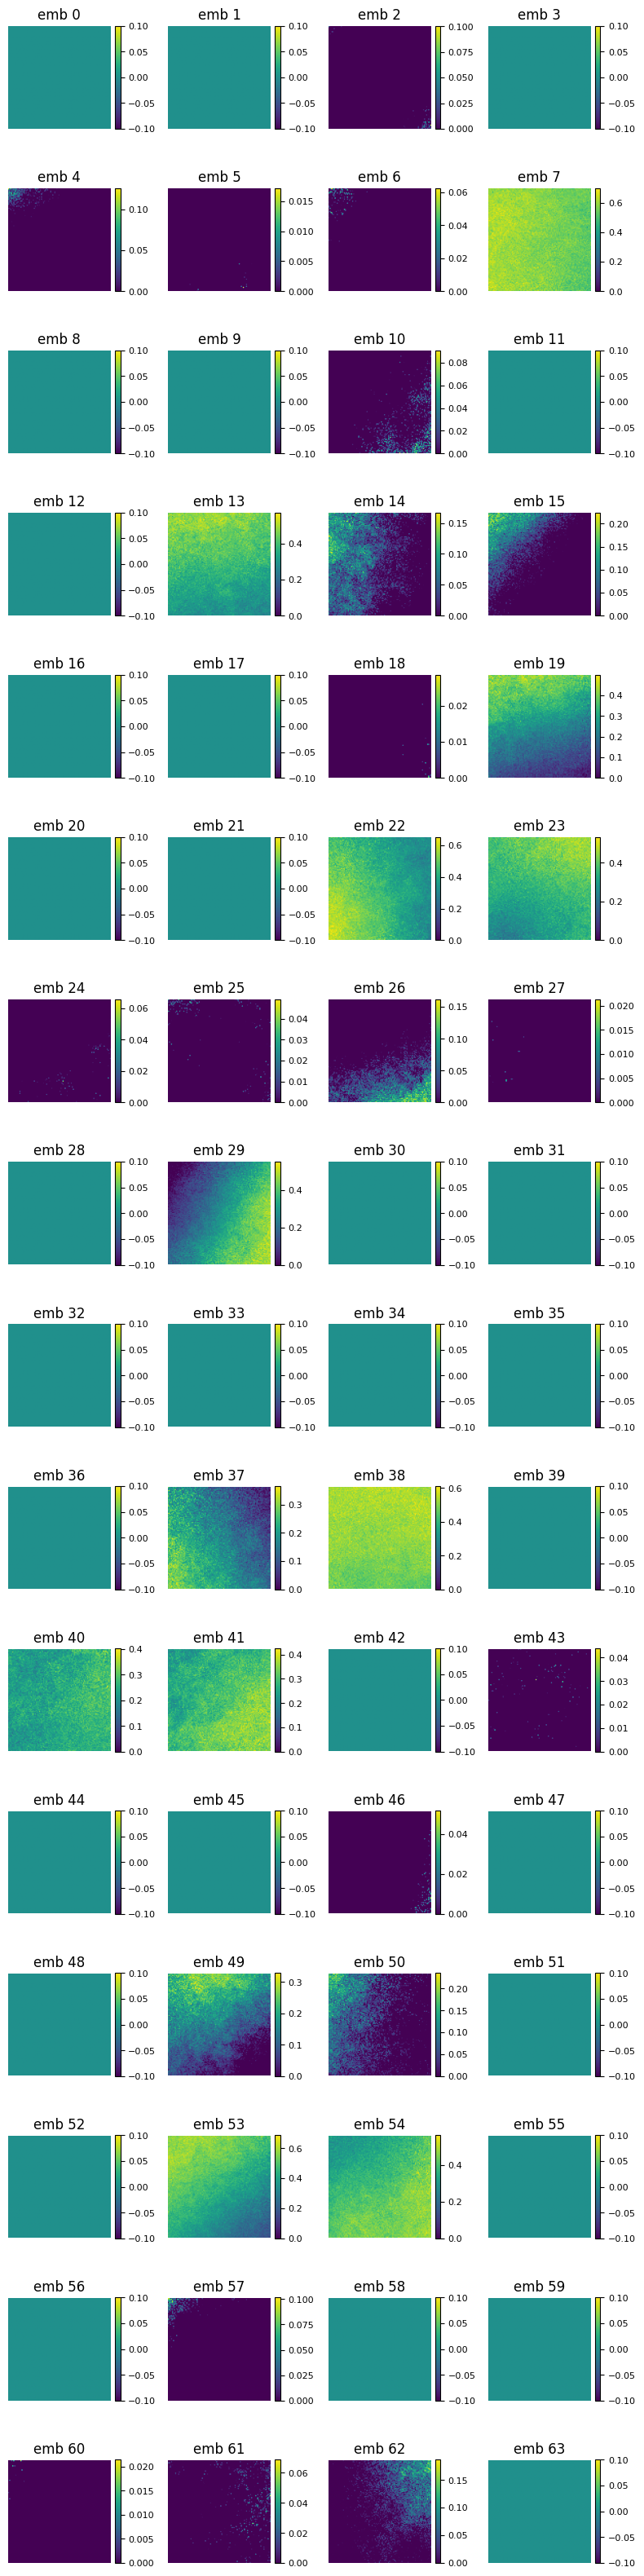

In [181]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    fig, ax = plt.subplots(16, 4, figsize=(8,32))
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].axis('off')
        ax[i].set_title(f'emb {i}')
        a = ax[i].imshow(h[keys[0]][:,i].reshape(100,100),vmin=0.)
        cbar = plt.colorbar(a, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    plt.show()

In [184]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import h5py
# channels = [0,3,12,16,41,45,49,59]
channels = [49,53,54]
model.generate_by_range(
    orig_shape=dataset.shape,
    generator_iters=50,
    averaging_number=50,
    channels=channels,
    overwrite=True,
    )

creating /home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_gauss_k3/_embedding.h5 file


100%|██████████| 50/50 [00:00<00:00, 74.26it/s]


/tmp/ipykernel_1772908/1271370534.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', generator_iters)


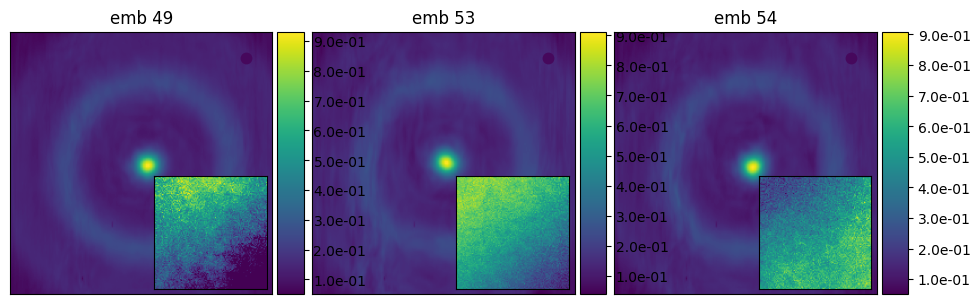

In [186]:
# which iter
i = 0
shape_ = [100, 100, 176, 176]
generator_iters = 50
cmap = plt.cm.get_cmap('viridis', generator_iters)

fig, ax = layout_fig(len(channels), 4, figsize=(len(channels)*4,16))
ax = ax.flatten()
with h5py.File(model.gen_h5_path, 'r+') as h:
    data = h[model.check]
    for j in range(len(channels)):
        with h5py.File(model.emb_h5_path, 'r+') as h_emb: emb = h_emb[f'embedding_{model.check}'][:,channels[j]]
        imagemap(ax[j], data[i,j])    
    
        pt = int(shape_[-1]*0.1)
        ax[j].plot(shape_[-1]-pt-1,pt, marker='o', markeredgewidth=0.0, markersize=pt*0.5,
                    markerfacecolor=cmap((i+1)/generator_iters))

        axes_in = ax[j].inset_axes([0.55, 0.02, 0.43, 0.43])


        # plots the embedding and formats embedding
        imagemap(axes_in, 
                    emb.reshape(shape_[0],shape_[1]), 
                    colorbars=False)
        ax[j].set_title(f'emb {channels[j]}')
    plt.show()

### 22,22 model 3k, l1

In [192]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=Gaussian_Sampler,
                     sampler_kwargs={'dset': dataset,
                                     'orig_shape': dataset.data.shape,
                                     'batch_size': 64,
                                     'gaussian_std': 0.5,
                                     'num_neighbors': 8},
                     collate_fn=Gaussian_Sampler.custom_collate_fn,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 64,
                                               'kernel_size': 3,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 3.1415,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [3,3], 
                                        'embedding_size': 64, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 64,
                                        'kernel_size': 3,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [11,11], 
                                        'upsampling_list': [4,4], 
                                        'embedding_size': 64, 
                                        'conv_size': 64,
                                        'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                  #    # STEM AE kwargs:
                  #    encoder_step_size=[176, 176],
                  #    pooling_list=[4],
                  #    decoder_step_size=[22, 22],
                  #    upsampling_list=[8],
                  #    embedding_size=32,
                  #    conv_size=128,
                  #   #  device='cuda:1',
                  #    learning_rate=3e-5
                    )

In [193]:
for i in range(10):
    model.Train(dataset.log_data,
                coef_1=i/5*10e-5,
                epoch_=i,
                epochs=i+2,
                with_scheduler=False,
                folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_gauss_k3/",
                # batch_size=32,
        )
    

 99%|█████████▉| 155/156 [01:09<00:00,  2.22it/s]


Epoch: 002/003 | Train Loss: 0.0162
.............................


 99%|█████████▉| 155/156 [01:10<00:00,  2.21it/s]


Epoch: 003/004 | Train Loss: 0.0085
.............................


 99%|█████████▉| 155/156 [01:11<00:00,  2.18it/s]


Epoch: 004/005 | Train Loss: 0.0083
.............................


 99%|█████████▉| 155/156 [01:10<00:00,  2.21it/s]


Epoch: 005/006 | Train Loss: 0.0082
.............................


 99%|█████████▉| 155/156 [01:10<00:00,  2.21it/s]


Epoch: 006/007 | Train Loss: 0.0082
.............................


 99%|█████████▉| 155/156 [01:09<00:00,  2.23it/s]


Epoch: 007/008 | Train Loss: 0.0082
.............................


 99%|█████████▉| 155/156 [01:09<00:00,  2.22it/s]


Epoch: 008/009 | Train Loss: 0.0082
.............................


 18%|█▊        | 28/156 [00:13<00:59,  2.15it/s]


KeyboardInterrupt: 

In [194]:
# checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_samp_k3/(2024-11-26_14-46-32)_epoch:0009_trainloss:3.6785e-02.pkl' 


# model.checkpoint = checkpoint
# model.load_weights(checkpoint)

In [195]:
model.get_embeddings(dataset.log_data, batch_size=32)


creating new embedding and affine h5 datasets


100%|██████████| 313/313 [00:23<00:00, 13.51it/s]


/tmp/ipykernel_1772908/3103051841.py:15: RuntimeWarning: invalid value encountered in arccos
  acos = np.arccos(rotation[:,0])


<Figure size 640x480 with 0 Axes>

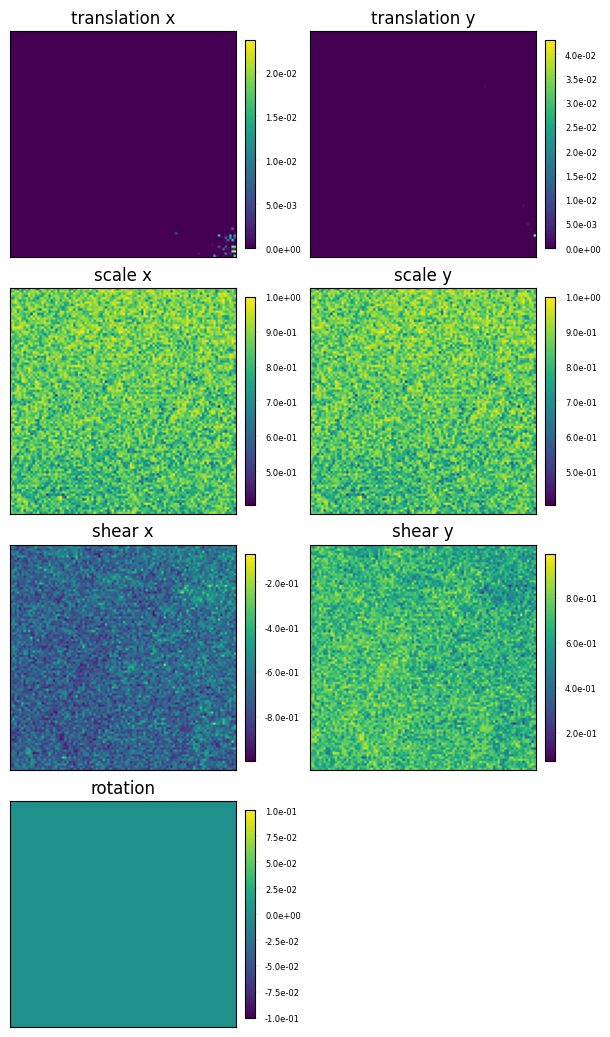

In [196]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    keys=list(h.keys())
    plt.clf();plt.clf()
    affines([ h[keys[2]][:], h[keys[3]][:], h[keys[4]][:], h[keys[1]][:]],
            shape_=[100, 100,176,176], 
            scale=True,
            shear=True,
            trans=True,
            rot=True)

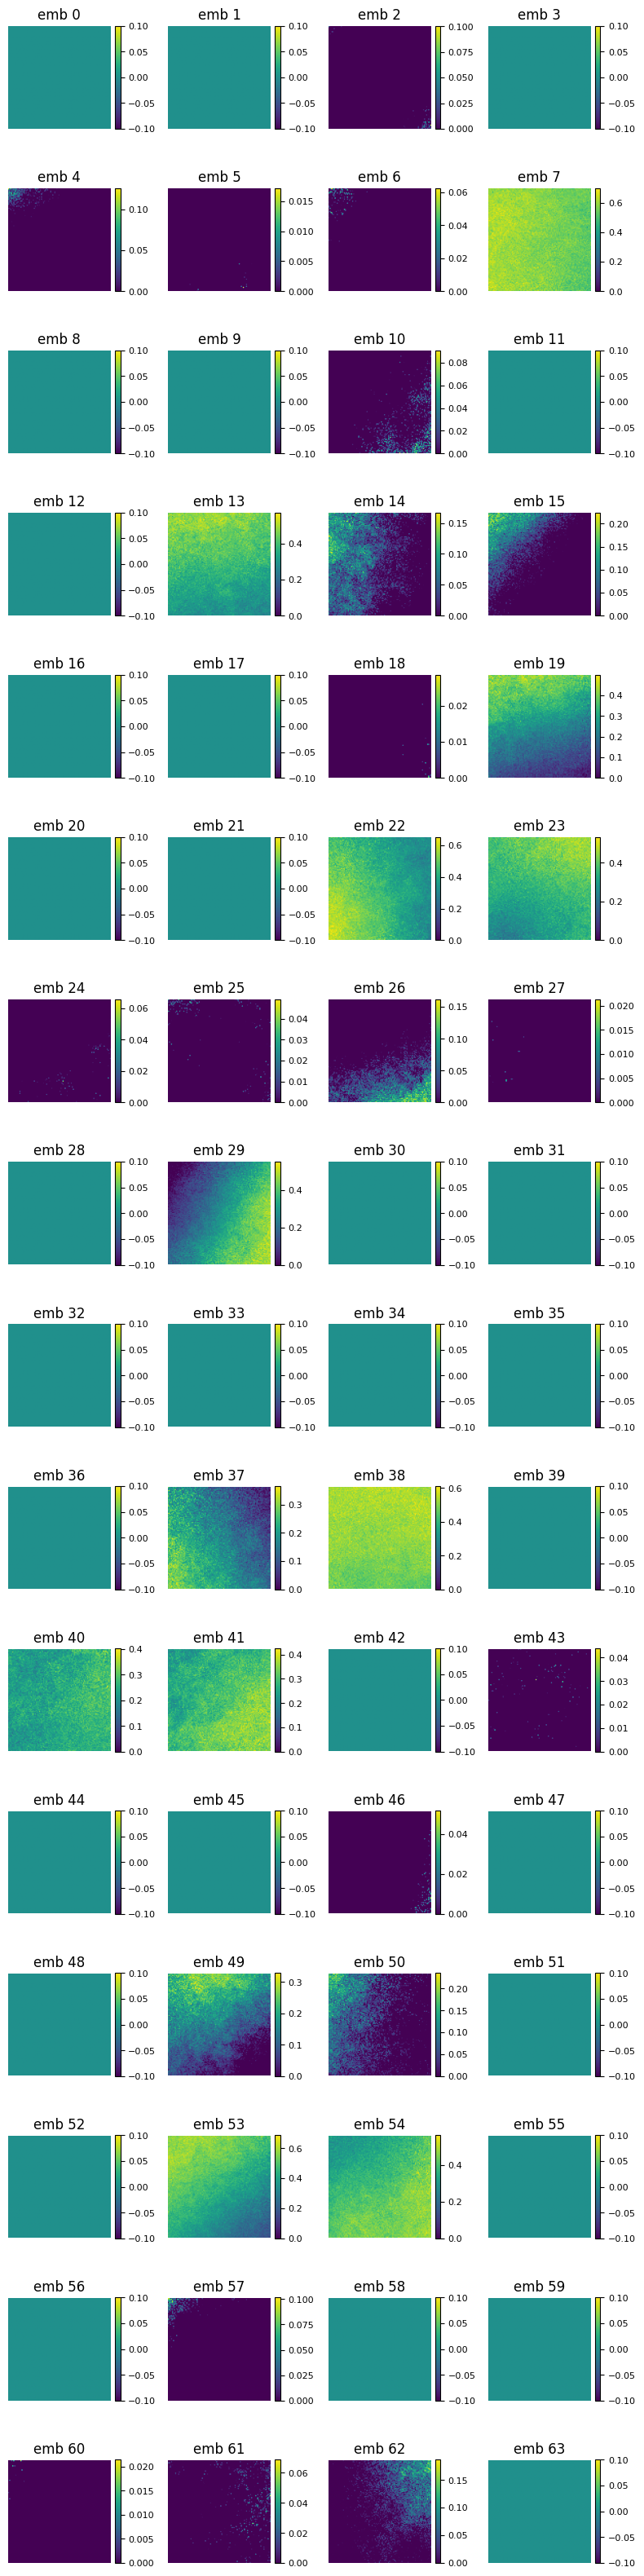

In [197]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    fig, ax = plt.subplots(16, 4, figsize=(8,32))
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].axis('off')
        ax[i].set_title(f'emb {i}')
        a = ax[i].imshow(h[keys[0]][:,i].reshape(100,100),vmin=0.)
        cbar = plt.colorbar(a, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    plt.show()

In [200]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import h5py
# channels = [0,3,12,16,41,45,49,59]
channels = [40,41,51,54]
model.generate_by_range(
    orig_shape=dataset.shape,
    generator_iters=50,
    averaging_number=50,
    channels=channels,
    overwrite=True,
    )

creating /home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_gauss_k3/_embedding.h5 file


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 49.22it/s]


/tmp/ipykernel_1772908/469231996.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', generator_iters)


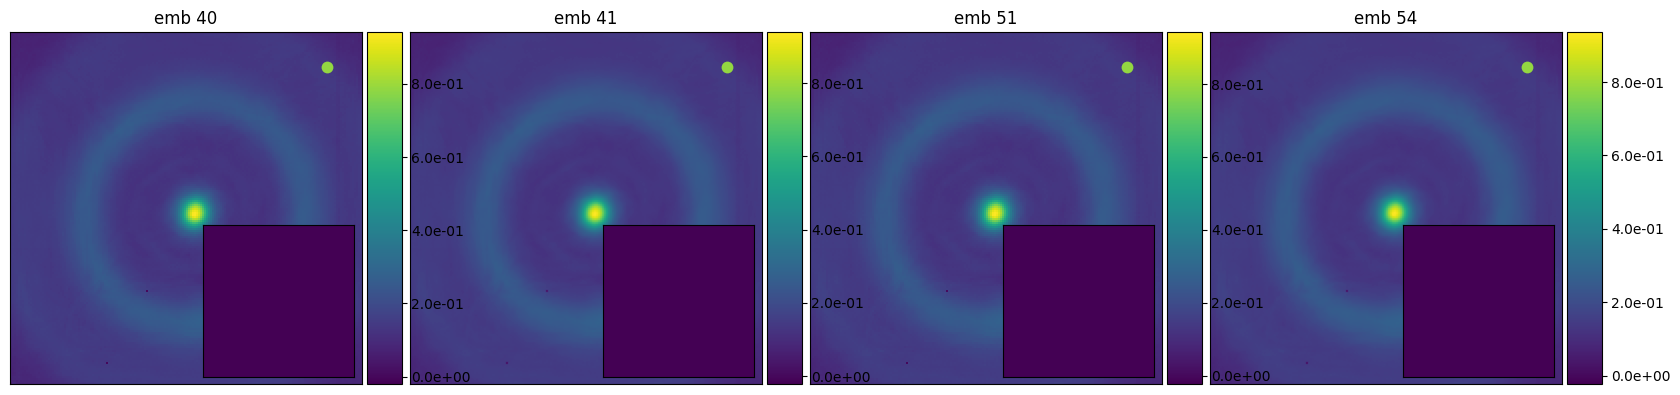

In [201]:
# which iter
i = 40
shape_ = [100, 100, 176, 176]
generator_iters = 50
cmap = plt.cm.get_cmap('viridis', generator_iters)

fig, ax = layout_fig(len(channels), 4, figsize=(len(channels)*4,16))
ax = ax.flatten()
with h5py.File(model.gen_h5_path, 'r+') as h:
    data = h[model.check]
    for j in range(len(channels)):
        with h5py.File(model.emb_h5_path, 'r+') as h_emb: emb = h_emb[f'embedding_{model.check}'][:,channels[j]]
        imagemap(ax[j], data[i,j])    
    
        pt = int(shape_[-1]*0.1)
        ax[j].plot(shape_[-1]-pt-1,pt, marker='o', markeredgewidth=0.0, markersize=pt*0.5,
                    markerfacecolor=cmap((i+1)/generator_iters))

        axes_in = ax[j].inset_axes([0.55, 0.02, 0.43, 0.43])


        # plots the embedding and formats embedding
        imagemap(axes_in, 
                    emb.reshape(shape_[0],shape_[1]), 
                    colorbars=False)
        ax[j].set_title(f'emb {channels[j]}')
    plt.show()

### 22,22 model 3k, l1 scheduling and lower lr

In [235]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3', learning_rate=3e-5,
                     sampler=Gaussian_Sampler,
                     sampler_kwargs={'dset': dataset,
                                     'orig_shape': dataset.data.shape,
                                     'batch_size': 64,
                                     'gaussian_std': 0.5,
                                     'num_neighbors': 8},
                     collate_fn=Gaussian_Sampler.custom_collate_fn,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 64,
                                               'kernel_size': 3,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 3.1416,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [3,3], 
                                        'embedding_size': 32, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 64,
                                        'kernel_size': 3,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [11,11], 
                                        'upsampling_list': [4,4], 
                                        'embedding_size': 32, 
                                        'conv_size': 64,
                                        'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                  #    # STEM AE kwargs:
                  #    encoder_step_size=[176, 176],
                  #    pooling_list=[4],
                  #    decoder_step_size=[22, 22],
                  #    upsampling_list=[8],
                  #    embedding_size=32,
                  #    conv_size=128,
                  #   #  device='cuda:1',
                  #    learning_rate=3e-5
                    )

In [236]:
for i in range(10):
    model.Train(dataset.log_data,
                coef_1=i/5*10e-4,
                epoch_=i,
                epochs=i+2,
                with_scheduler=False,
                folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_gauss_k3/",
                # batch_size=32,
        )
    

 99%|█████████▉| 155/156 [01:09<00:00,  2.24it/s]


Epoch: 001/002 | Train Loss: 0.0215
.............................


 99%|█████████▉| 155/156 [01:09<00:00,  2.21it/s]


Epoch: 002/003 | Train Loss: 0.0131
.............................


 99%|█████████▉| 155/156 [01:09<00:00,  2.22it/s]


Epoch: 003/004 | Train Loss: 0.0125
.............................


 99%|█████████▉| 155/156 [01:09<00:00,  2.22it/s]


Epoch: 004/005 | Train Loss: 0.0120
.............................


 99%|█████████▉| 155/156 [01:11<00:00,  2.17it/s]


Epoch: 005/006 | Train Loss: 0.0117
.............................


 99%|█████████▉| 155/156 [01:09<00:00,  2.24it/s]


Epoch: 006/007 | Train Loss: 0.0117
.............................


 99%|█████████▉| 155/156 [01:09<00:00,  2.23it/s]


Epoch: 007/008 | Train Loss: 0.0117
.............................


  4%|▍         | 6/156 [00:03<01:16,  1.95it/s]


KeyboardInterrupt: 

In [ ]:
# checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_samp_k3/(2024-11-26_14-46-32)_epoch:0009_trainloss:3.6785e-02.pkl' 


# model.checkpoint = checkpoint
# model.load_weights(checkpoint)

In [237]:
model.get_embeddings(dataset.log_data, batch_size=32)
with h5py.File(model.emb_h5_path, 'r+') as h:
    keys=list(h.keys())
    print(keys)


creating new embedding and affine h5 datasets


100%|██████████| 313/313 [00:23<00:00, 13.37it/s]


In [239]:
with h5py.File(model.emb_h5_path, 'r+') as h:
    keys_=list(h.keys())
keys_

['embedding_(2024-12-03_15-01-32)_epoch:0003_trainloss:8.1738e-03',
 'embedding_(2024-12-03_15-28-36)_epoch:0008_trainloss:8.1845e-03',
 'embedding_(2024-12-03_15-46-36)_epoch:0007_trainloss:8.2856e-03',
 'embedding_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02',
 'rotation_(2024-12-03_15-01-32)_epoch:0003_trainloss:8.1738e-03',
 'rotation_(2024-12-03_15-28-36)_epoch:0008_trainloss:8.1845e-03',
 'rotation_(2024-12-03_15-46-36)_epoch:0007_trainloss:8.2856e-03',
 'rotation_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02',
 'scale_(2024-12-03_15-01-32)_epoch:0003_trainloss:8.1738e-03',
 'scale_(2024-12-03_15-28-36)_epoch:0008_trainloss:8.1845e-03',
 'scale_(2024-12-03_15-46-36)_epoch:0007_trainloss:8.2856e-03',
 'scale_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02',
 'shear_(2024-12-03_15-01-32)_epoch:0003_trainloss:8.1738e-03',
 'shear_(2024-12-03_15-28-36)_epoch:0008_trainloss:8.1845e-03',
 'shear_(2024-12-03_15-46-36)_epoch:0007_trainloss:8.2856e-03',
 'shear_(202

In [242]:
keys = [ 'embedding_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02',
 'rotation_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02',
 'scale_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02',
 'shear_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02',
 'translation_(2024-12-03_16-17-54)_epoch:0007_trainloss:1.1704e-02']

<Figure size 640x480 with 0 Axes>

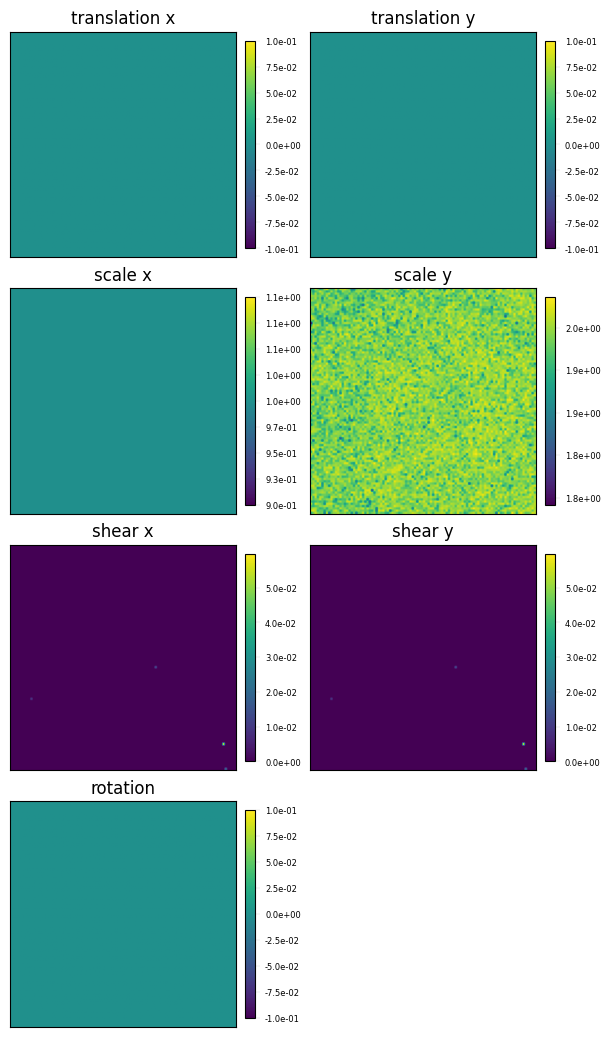

In [243]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    plt.clf();plt.clf()
    affines([ h[keys[2]][:], h[keys[3]][:], h[keys[4]][:], h[keys[1]][:]],
            shape_=[100, 100, 176, 176], 
            scale=True,
            shear=True,
            trans=True,
            rot=True)

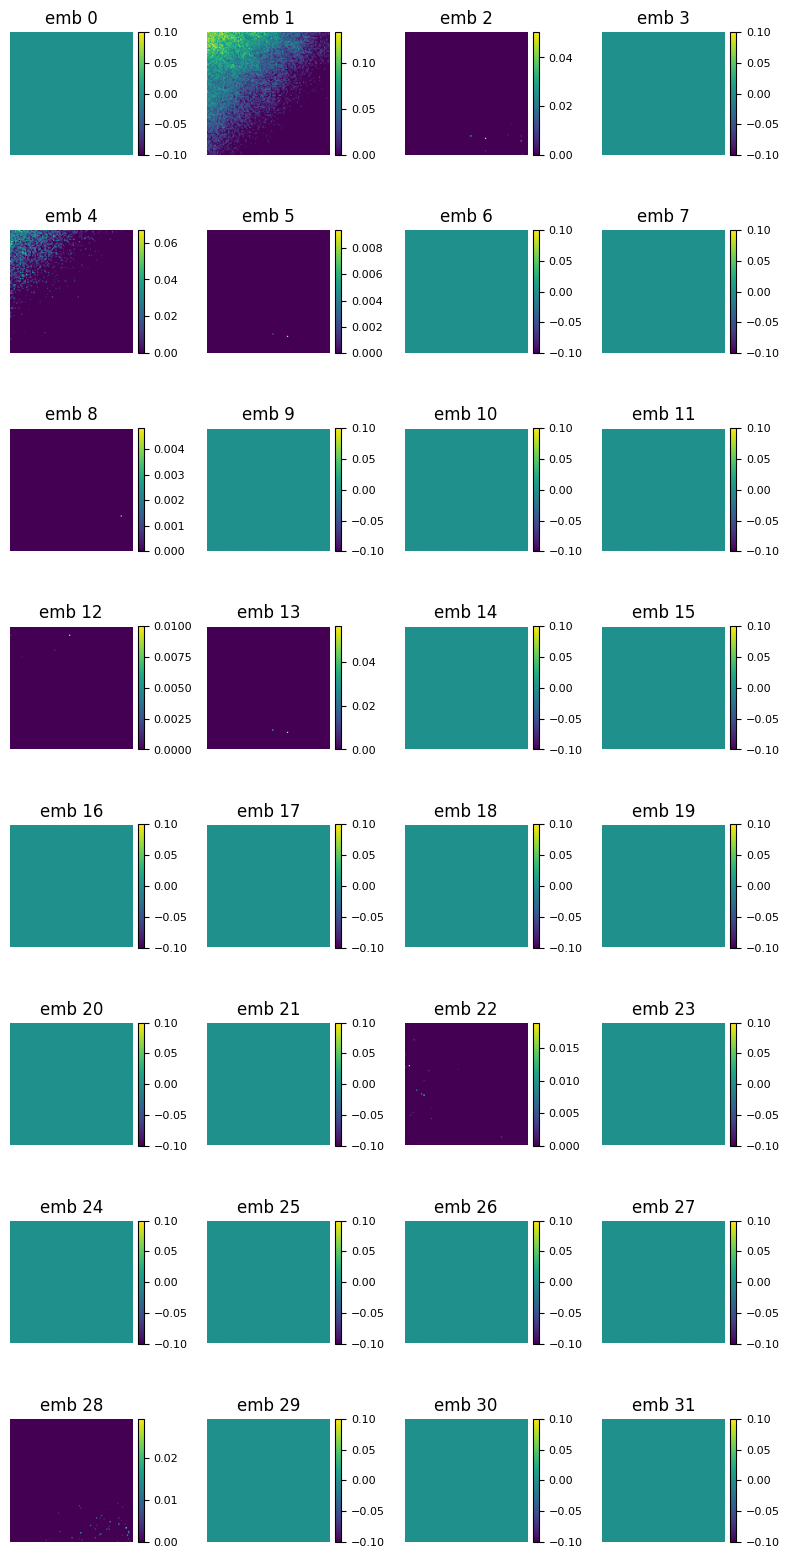

In [245]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    len_,ch = h[keys[0]].shape
    fig, ax = plt.subplots(ch//4, 4, figsize=(ch//4,ch//2))
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].axis('off')
        ax[i].set_title(f'emb {i}')
        a = ax[i].imshow(h[keys[0]][:,i].reshape(100,100),vmin=0.)
        cbar = plt.colorbar(a, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    plt.show()

In [246]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import h5py
# channels = [0,3,12,16,41,45,49,59]
channels = [1,2,4]
model.generate_by_range(
    orig_shape=dataset.shape,
    generator_iters=50,
    averaging_number=50,
    channels=channels,
    overwrite=True,
    )

creating /home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_gauss_k3/_embedding.h5 file


100%|██████████| 50/50 [00:00<00:00, 81.84it/s]


/tmp/ipykernel_1772908/469231996.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', generator_iters)


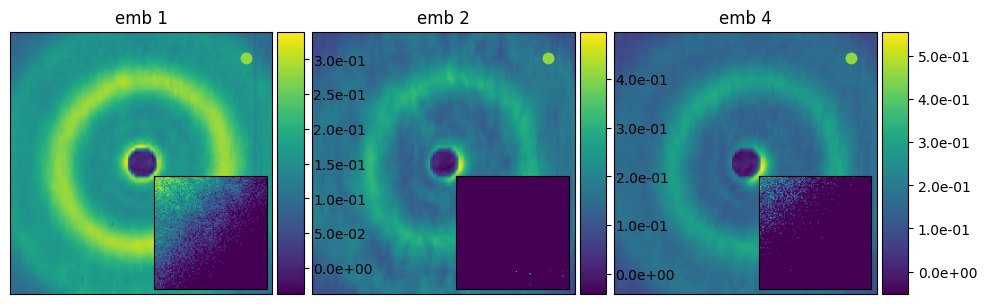

In [247]:
# which iter
i = 40
shape_ = [100, 100, 176, 176]
generator_iters = 50
cmap = plt.cm.get_cmap('viridis', generator_iters)

fig, ax = layout_fig(len(channels), 4, figsize=(len(channels)*4,16))
ax = ax.flatten()
with h5py.File(model.gen_h5_path, 'r+') as h:
    data = h[model.check]
    for j in range(len(channels)):
        with h5py.File(model.emb_h5_path, 'r+') as h_emb: emb = h_emb[f'embedding_{model.check}'][:,channels[j]]
        imagemap(ax[j], data[i,j])    
    
        pt = int(shape_[-1]*0.1)
        ax[j].plot(shape_[-1]-pt-1,pt, marker='o', markeredgewidth=0.0, markersize=pt*0.5,
                    markerfacecolor=cmap((i+1)/generator_iters))

        axes_in = ax[j].inset_axes([0.55, 0.02, 0.43, 0.43])


        # plots the embedding and formats embedding
        imagemap(axes_in, 
                    emb.reshape(shape_[0],shape_[1]), 
                    colorbars=False)
        ax[j].set_title(f'emb {channels[j]}')
    plt.show()

TypeError: 'Axes' object is not callable

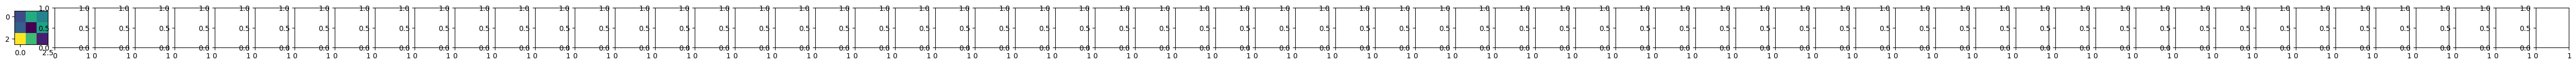

In [252]:
for i, (name, param) in enumerate(model.autoencoder.named_parameters()):
    if i >2: break
    size_ = param.size()
    fig,ax = plt.subplots(size_[1], size_[0], figsize=(size_[0],size_[1]))
    ax= ax.reshape(size_[0], size_[1])
    for i in range(size_[0]):
        for j in range(size_[1]):
            ax[i,j].imshow(param[i,j].detach().cpu().numpy())
            ax[i,j].axes('off')
    fig.suptitle(name, param.size())
    fig.show()